In [1]:
import os
import shutil
from pathlib import Path

import jax.random as jr
import jax.numpy as jnp
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.gaussian_obs import add0



In [2]:
def clean_dir(path):
    paths_to_remove = []
    _dir = Path(path)
    for i, exp in enumerate(_dir.glob('*')):
        exp_path = Path(exp)
        contents = []
        for f in exp_path.glob('*'):
            contents.append(os.path.split(f)[1])
        if 'res.pickle' not in contents: 
            shutil.rmtree(exp_path)
            print('Removing unfinished experiment')

# def clean_temp(path):
#     Lpaths = get_model_paths(10, 'true-init')
#     results = {}
#     for path in Lpaths:
#         cfg_path = os.path.join(path, '.hydra/config.yaml')
#         cfg = OmegaConf.load(cfg_path)
#         obs_var = cfg.obs.ov2
#         if 'support' not in list(cfg.model.keys()):
#             print(cfg)
#             # shutil.rmtree(path)
#             print('Removing old experiment')
#         # print(obs_var)
#         # print(cfg)

#         # res = pickle_open(os.path.join(path, 'res.pickle'))
#         # res['cfg'] = cfg
#         # results[obs_var] = res

In [26]:
def load_results(paths, ovs_sel, **kwargs):
    Lpaths = get_model_paths(paths, **kwargs)
    results = {}
    obs_vars = []
    for path in Lpaths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)
        obs_var = cfg.obs.ov2
        if ovs_sel is not None:
            if obs_var in ovs_sel:
                obs_vars.append(obs_var)

    ovs = jnp.array(obs_vars)
    if ovs.size == jnp.unique(ovs).size:

        for path in Lpaths:
            cfg_path = os.path.join(path, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)
            obs_var = cfg.obs.ov2

            res = pickle_open(os.path.join(path, 'res.pickle'))
            res['cfg'] = cfg
            results[obs_var] = res

    else:
        print('Duplicates found for obs_var - returning empty dict.')

    return results

def get_model_paths(paths, **kwargs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if cfg.latent.L == L:
                if cfg.model.emiters == emiters:
                    if cfg.model.init == init:
                        if cfg.model.scale_init == scale_init:
                            if supp is not None:
                                if 'support' in list(cfg.model.keys()):
                                    if cfg.model.support == supp:
                                            sel_paths.append(exp)
                            else:
                                if 'support' not in list(cfg.model.keys()):
                                    if cfg.model.emiters == emiters:
                                        sel_paths.append(exp)
                                else:
                                    if cfg.model.support == supp:
                                            sel_paths.append(exp)
    return sel_paths

In [ ]:
from cohlib.utils import pickle_save, gamma_root, pickle_open
# from cohlib.jax.gamma_create import k2_full

In [11]:
from cohlib.utils import gamma_root
def compute_naive_and_oracle(cfg):
    lcfg = cfg.latent
    ocfg = cfg.obs

    if cfg.latent.gamma == 'k2-single-10':
        gamma_path = os.path.join(gamma_root(), f"{cfg.latent.gamma}.pickle")
        gamma_load = pickle_open(gamma_path)
        gamma_full = gamma_load['gamma']
    elif cfg.latent.gamma == 'k2-full-10':
        flow = lcfg.freq_low
        fhigh = lcfg.freq_high
        sp_target = lcfg.scale_power_target
        sp_offtarget = lcfg.scale_power_offtarget
        gamma_path = os.path.join(gamma_root(), f"k2-full{flow}-{fhigh}-10-{sp_target}-{sp_offtarget}.pickle")
        gamma_load = pickle_open(gamma_path)
        gamma_full = gamma_load['gamma']
    else:
        raise ValueError()

    freqs = gamma_load['freqs']
    N = freqs.size
    nz = gamma_load['nonzero_inds']
    K = gamma_full.shape[-1]

    gamma_full *= lcfg.scale

    lrk = jr.key(lcfg.seed)
    zs = sample_from_gamma(lrk, gamma_full, lcfg.L)
    gamma_est_oracle = jnp.einsum('nkl,nil->nkil', zs, zs.conj()).mean(-1)



    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    ork = jr.key(ocfg.seed)


    obs_var = ocfg.ov1 * 10**ocfg.ov2
    obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

    obs_mc = obs - obs.mean(0)[None,:,:]
    obs_f = jnp.fft.rfft(obs_mc, axis=0)[1:,:,:]
    gamma_est_naive = jnp.einsum('nkl,nil->nkil', obs_f, obs_f.conj()).mean(-1)

    return gamma_est_oracle, gamma_est_naive

In [ ]:
def plot_data(res, k=0):
    gamma_true_full = res['gamma_true_full']
    lcfg = res['cfg'].latent
    ocfg = res['cfg'].obs

    lrk = jr.key(lcfg.seed)
    zs = sample_from_gamma(lrk, gamma_true_full, lcfg.L)

    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    ork = jr.key(ocfg.seed)


    obs_var = ocfg.ov1 * 10**ocfg.ov2
    obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

    fig, ax = plt.subplots(2,1,figsize=(5,3))
    for l in range(3):
        ax[0].plot(xs[:,k,l])
        ax[1].plot(obs[:,k,l])
    plt.tight_layout()


In [ ]:
def plot_result_allfreqs(ax, res1, db, fshow, res2=None, k=0, leg=False, show_naive=True):
    gamma_init = res1['gamma_init']
    gamma_true_full= res1['gamma_true_full']

    m1_nz = res1['gamma']
    nz_m1 = jnp.arange(m1_nz.shape[0])
    gamma_true = gamma_true_full[nz_m1,:,:]


    m1 = jnp.zeros_like(gamma_true)
    gamma_model_m1 = m1.at[nz_m1,:,:].set(m1_nz)

    gamma_oracle, gamma_naive = compute_naive_and_oracle(res1['cfg'])

    gamma_oracle = gamma_oracle[nz_m1,:,:]
    gamma_naive = gamma_naive[nz_m1,:,:]

    # print(gamma_true)
    S_true = pow(gamma_true, k, db, fshow)
    S_init = pow(gamma_init, k, db, fshow)
    # print(S_true)
    S_oracle = pow(gamma_oracle, k, db, fshow)
    S_naive = pow(gamma_naive, k, db, fshow)
    S_model_m1 = pow(gamma_model_m1, k, db, fshow)


    ax.plot(S_true, 'k', linewidth=2, label='True')
    ax.plot(S_oracle, 'tab:green', label='Oracle')
    ax.plot(S_model_m1, 'tab:blue', label='Model')
    ax.plot(S_init, 'tab:orange', linestyle='--', label='Init')
    if show_naive:
        ax.plot(S_naive, 'tab:red', label='Naive')
    if res2 is not None:
        m2_nz = res_m2['gamma']
        m2 = jnp.zeros_like(gamma_true)
        gamma_model_m2 = m2.at[nz,:,:].set(m2_nz)
        S_model_m2 = pow(gamma_model_m2, k, db, fshow)
        ax.plot(S_model_m2, 'tab:green', label='Model2')

    if leg == True:
        ax.legend()

In [12]:
def pow(gamma, k, db=False, freq_inds=None):
    if freq_inds is None:
        freq_inds = jnp.arange(gamma.shape[0])
    S = gamma[freq_inds,k,k].real
    if db is True:
        S = 10*jnp.log10(S+1e-15)
    return S


### Load Gamma and Jax Results

In [13]:
from cohlib.utils import gamma_root
# gamma_name = 'k2-single-10'
flow=1
fhigh=50
spt=5
spot=1
gamma_path = os.path.join(gamma_root(), f"k2-full{flow}-{fhigh}-10-{spt}-{spot}.pickle")
gamma_load = pickle_open(gamma_path)
gamma_raw = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']

In [21]:
clean_dir(res_paths[0])

scale_init = 10
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/batch_submit/outputs/2024-08-07']


L = 25
init = 'flat-init'
emiters = 20
scale_init = 10
ovs_sel = None

supp_full = [0, 50]
nz_fit50 = jnp.where((freqs >= supp_full[0]) & (freqs <= supp_full[1]))
supp = [0, 50]
res1 = load_results(res_paths, ovs_sel, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
gamma_oracle_jaxruns, _ = compute_naive_and_oracle(res_to_plot_flat[-2]['cfg'])

In [34]:
# simulate from latent
sp_target = spt
sp_offtarget = spot
lseed = 7
gamma_path = os.path.join(gamma_root(), f"k2-full{flow}-{fhigh}-10-{sp_target}-{sp_offtarget}.pickle")
gamma_load = pickle_open(gamma_path)

gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
N = freqs.size
nz = gamma_load['nonzero_inds']
nz_target = jnp.array([9])
K = gamma_full.shape[-1]

lrk = jr.key(lseed)

zs = sample_from_gamma(lrk, gamma_full, L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)


### Load Old Model Results and Plot Jax vs Old

In [35]:
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
def load_old(ov2, K=2, L=25, sample_length=1000, C=1, ov1=1.0, seed=8, etype="approx", hess_mod=False):
    ov2 = float(ov2)
    if hess_mod is True:
        model_path = f'{exp_path}/saved/fitted_models/scale_hess_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_hessmod_path)
    else:
        model_path = f'{exp_path}/saved/fitted_models/scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)

    return model_load

def plot_old(ov2, ax, linecolor='tab:blue', K=2, L=25, sample_length=1000, C=1, ov1=1.0, seed=8, etype="approx", hess_mod=False):
    ov2 = float(ov2)

    model_load = load_old(ov2, K, L, sample_length, C, ov1, seed, etype, hess_mod)

    Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars=100, invert=True)
    J = 500

    S_model = model_load['Gamma'][:,0,0].real #* ((2*J )**2 * (np.pi / (J + 1))**2)

    if dB is True:
        S_model = 10*jnp.log10(S_model)

    if hess_mod is True:
        ax.plot(S_model, linecolor, label='Model - Old')
    else:
        ax.plot(S_model, linecolor, label='Model - Old')

In [43]:
def plot_result_allfreqs(ax, res1, db, fshow, res2=None, k=0, leg=False, show_naive=True):
    gamma_init = res1['gamma_init']
    gamma_true_full= res1['gamma_true_full']

    m1_nz = res1['gamma']
    nz_m1 = jnp.arange(m1_nz.shape[0])
    gamma_true = gamma_true_full[nz_m1,:,:]


    m1 = jnp.zeros_like(gamma_true)
    gamma_model_m1 = m1.at[nz_m1,:,:].set(m1_nz)

    gamma_oracle, gamma_naive = compute_naive_and_oracle(res1['cfg'])

    gamma_oracle = gamma_oracle[nz_m1,:,:]
    gamma_naive = gamma_naive[nz_m1,:,:]

    # print(gamma_true)
    S_true = pow(gamma_true, k, db, fshow)
    S_init = pow(gamma_init, k, db, fshow)
    # print(S_true)
    S_oracle = pow(gamma_oracle, k, db, fshow)
    S_naive = pow(gamma_naive, k, db, fshow)
    S_model_m1 = pow(gamma_model_m1, k, db, fshow)


    # ax.plot(S_true, 'k', linewidth=2, label='True')
    # ax.plot(S_init, 'tab:orange', linestyle='--', label='Init')
    # if show_naive:
    #     ax.plot(S_naive, 'tab:red', label='Naive')
    # if res2 is not None:
    #     m2_nz = res_m2['gamma']
    #     m2 = jnp.zeros_like(gamma_true)
    #     gamma_model_m2 = m2.at[nz,:,:].set(m2_nz)
    #     S_model_m2 = pow(gamma_model_m2, k, db, fshow)
    #     ax.plot(S_model_m2, 'tab:green', label='Model2')

    ax.plot(S_naive, 'tab:purple', label='Naive')
    ax.plot(S_oracle, 'tab:green', linewidth=3, label='Oracle')
    ax.plot(S_model_m1, 'k', linewidth=2, linestyle='--', label='Model')

    if leg == True:
        ax.legend()

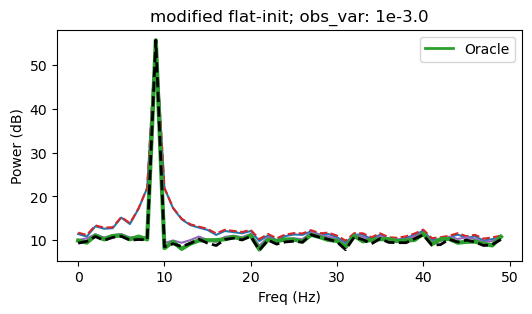

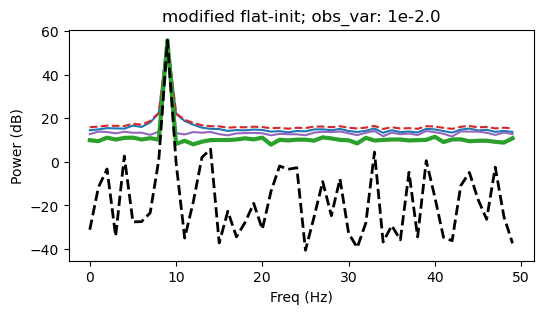

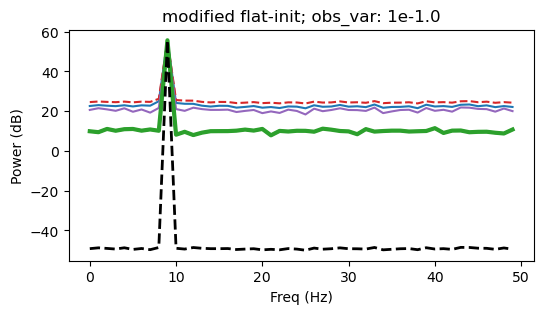

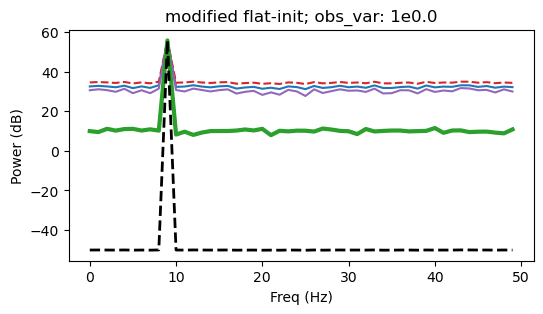

In [45]:
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
sample_length = 1000
C = 1
mu = 0.0
# ov1 = float(o1)
# ov2 = float(o2)
ov1 = 1.0
# ov2 = -2.0
exp_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/gaussian_observations'

gamma_oracle = jnp.einsum('jkl,jil->jkil', zs[nz,:,:], zs[nz,:,:].conj()).mean(-1)

dB = True
seed = 8
etype="approx"
# ovs = [-2]
ovs = [-3, -2, -1, 0]
for ov2 in ovs:
    ov2 = float(ov2)
    model_path = f'{exp_path}/saved/fitted_models/scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
    model_load = pickle_open(model_path)

    model_hessmod_path = f'{exp_path}/saved/fitted_models/scale_hess_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
    model_hessmod_load = pickle_open(model_hessmod_path)

    fig, ax = plt.subplots(figsize=(6,3))
    Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars=100, invert=True)
    J = 500

    # S_oracle = gamma_oracle[:,0,0].real
    S_model = model_load['Gamma'][:,0,0].real #* ((2*J )**2 * (np.pi / (J + 1))**2)
    # S_model_hessmod = model_hessmod_load['Gamma'][:,0,0].real #* ((2*J )**2 * (np.pi / (J + 1))**2)
    S_init = Gamma_init[:,0,0].real 
    S_true = gamma_full[:50,0,0].real 
    # S_naive = gamma_from_ys[:,0,0].real * (((J * np.pi)**2 / (J + 1)))

    if dB is True:
        S_oracle = 10*jnp.log10(S_oracle)
        S_model = 10*jnp.log10(S_model)
        S_model_hessmod = 10*jnp.log10(S_model_hessmod)
        S_init = 10*jnp.log10(S_init)
        # S_naive = 10*np.log10(S_naive)
        S_true = 10*jnp.log10(S_true)

    ax.plot(S_oracle, 'tab:green', linewidth=2, label='Oracle')
    ax.set_xlabel('Freq (Hz)')
    ax.set_title(f'flat-init; obs_var: 1e{ov2}')
    ax.set_title(f'modified flat-init; obs_var: 1e{ov2}')
    if dB is True:
        ax.set_ylabel('Power (dB)')
    else:
        ax.set_ylabel('Power ')
    if ov2 == -3:
        ax.legend()
    # plt.xlim([0,5])
    ax.plot(S_model, 'tab:blue', label='Model')
    ax.plot(S_model_hessmod, 'tab:red', linestyle='--', label='Modified Model')

    plot_result_allfreqs(ax, res_to_plot_flat[ov2], db=dB, fshow=fshow)
    # ax.set_xlim([5,15])
    # ax.set_ylim([0,10000])

In [ ]:
# So even after adjusting one potential source of problem (Hessian, we don't do any better... let's next look at what's going on in EM)

In [ ]:
def get_old_gamma_emlist(model_load):
    num_iters = len(model_load['track'][0])
    gamma_emlist = [model_load['track'][0][r]['gamma_rplus1'] for r in range(num_iters)]
    return gamma_emlist
def plot_spec_em_iters(ax, gamma_iter_list, k, nz=None, dB=False):
    if nz is None:
        nz = jnp.arange(gamma_iter_list[0].shape[0])
    num_iters = len(gamma_iter_list)
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    for r, c in enumerate(color): 
        gamma_r = gamma_iter_list[r]
        S_r = gamma_r[nz,k,k].real
        if dB is True:
            S_r = 10*jnp.log10(S_r)
        ax.plot(S_r, color=c, linewidth=2, alpha=0.5)

Text(0.5, 1.0, 'Jax')

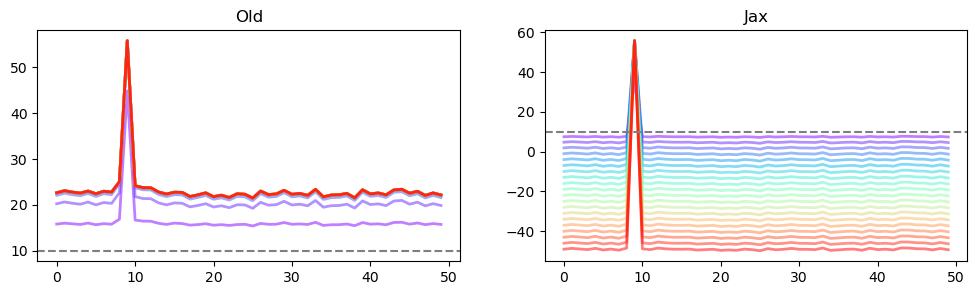

In [137]:
dB = True
ov = -1 
fig, ax = plt.subplots(1, 2, figsize=(12,3))

old_load = load_old(ov, hess_mod=False)
old_emlist = get_old_gamma_emlist(old_load)
new_emlist = res_to_plot_flat[ov]['track']['gamma']

plot_spec_em_iters(ax[0], old_emlist, 0, dB=dB)
plot_spec_em_iters(ax[1], new_emlist, 0, dB=dB)
ax[0].axhline(10, color='tab:grey', linestyle='--')
ax[0].set_title('Old')
ax[1].axhline(10, color='tab:grey', linestyle='--')
ax[1].set_title('Jax')

## ok, so these are behaving very differently... 
and we have seen that adjusting the Hessian actually makes thing worse... 

next steps:
- starting at flat initialization, walk through e-step outputs and m-step outputs for both versions 
- we already have the e-step map estimates saved can inspect those now (see below)
    - will need to convert as 

In [ ]:
from functools import partial
from cohlib.conv import conv_v_to_z
def conv_mus_vec_r2c(mus_vec, K):
    rs = mus_vec.reshape(2,-1).swapaxes(0,1)
    mus_complex = conv_v_to_z(rs, axis=0)
    return mus_complex

def conv_mus_r2c(mus, K, axis=1):
    return jnp.stack([conv_mus_vec_r2c(jnp.take(mus, l, axis=axis), K) for l in range(L)], axis=-1)

In [209]:
def quick_plot(ov, r, k, l, hess_mod_flag, absylim=None):
    old_load = load_old(ov, hess_mod=hess_mod_flag)
    jax_track = res_to_plot_flat[ov]['track']
    old_track = old_load['track'][0]
    old_track[0]['mus'].shape

    old_mus = old_track[r]['mus']
    jax_mus = jax_track['mus'][r]
    old_mus_crep = conv_mus_r2c(old_mus, 2, axis=0)

    fig, ax = plt.subplots(2,2, figsize=(6,5))
    ax[0,0].plot(jax_mus[:,k,l].real, label='Jax')
    ax[0,0].plot(old_mus_crep[:,k,l].real, label='Old')
    ax[0,0].set_xlabel('Freq')
    ax[0,0].set_title('Real coefs')
    ax[0,0].legend()


    ax[1,0].plot(jax_mus[:,k,l].imag)
    ax[1,0].plot(old_mus_crep[:,k,l].imag)
    ax[1,0].set_xlabel('Freq')
    ax[1,0].set_title('Imag coefs')

    if absylim is not None:
        ax[0,0].set_ylim([-absylim,absylim])
        ax[1,0].set_ylim([-absylim,absylim])

    ax[0,1].plot((jax_mus[:,k,l].real / old_mus_crep[:,k,l].real) , color='k', label='Real')
    ax[1,1].plot((jax_mus[:,k,l].imag / old_mus_crep[:,k,l].imag) , color='k', label='Imag')
    ax[0,1].set_title('Jax / Old (Real)')
    ax[1,1].set_title('Jax / Old (Imag)')
    ax[0,1].set_xlabel('Freq')
    ax[1,1].set_xlabel('Freq')
    if absylim is not None:
        ax[0,1].set_ylim([-2,2])
        ax[1,1].set_ylim([-2,2])

    fig.suptitle(f'EM Iter {r}')
    fig.tight_layout()

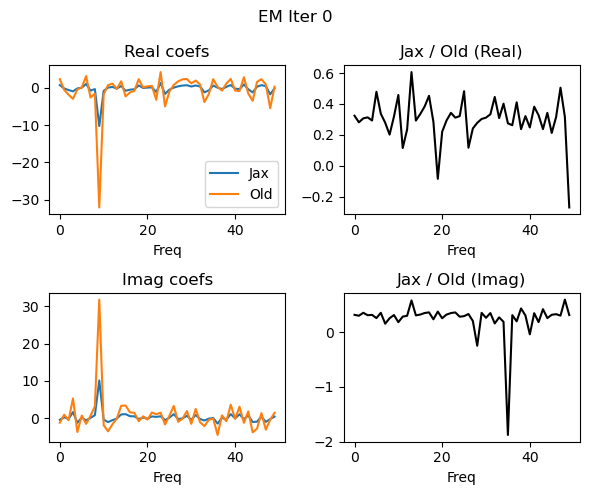

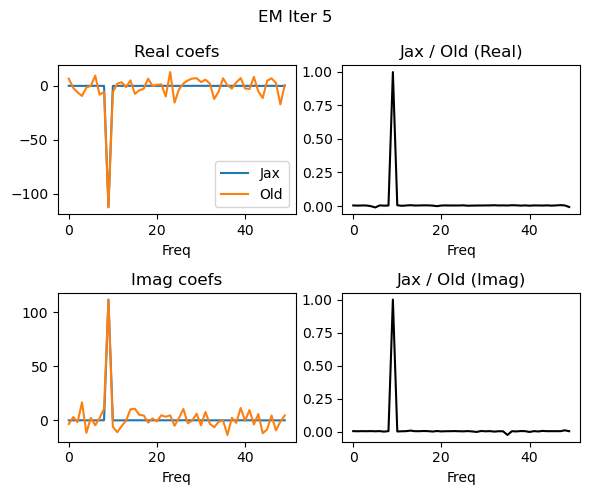

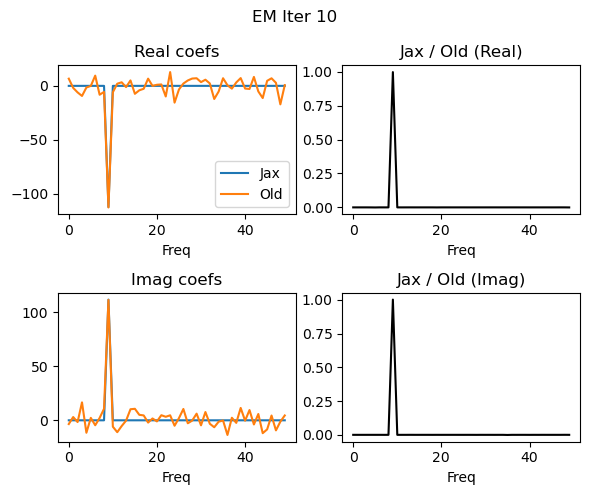

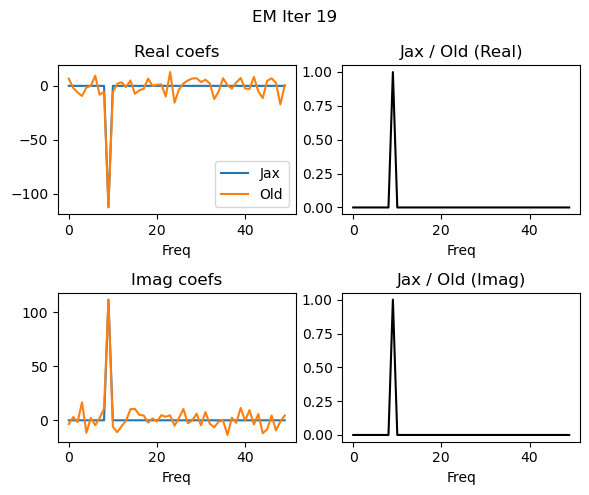

In [215]:
flag = False
ov = -1 
k = 0

l = 2
# for r in [0,2,4,6,8,10]:
for r in [0,5,10,19]:
    quick_plot(ov, r, k, l, flag, absylim=None)
# for r in [0,5,10,15]:
#     quick_plot(ov, r, k, l, flag, absylim=20)

## Cool... so will be very interesting to figure out what is happening here!

### Next let's look at:
- What happens on the first E-Step?
    - How do gradient / Hessian compare? 
- What happens in first M-Step
    - Are there any differences between the two methods other than inputs from E-Step?

- How does Gamma initiliaziation affect behavior between two? 

- Critically - what changes can we make to make Old behave like Jax?

See next notebook for continued work (compare_jax_vs_old2.ipynb)

In [78]:
def plot_comp_mus(old_track, jax_track, r, k, l):
    old_mus = old_track[r]['mus']
    jax_mus = jax_track['mus'][r]
    old_mus_crep = conv_mus_r2c(old_mus, 2, axis=0)

    plims_real = old_mus_crep.real.std(axis=0) * 20
    plims_imag = old_mus_crep.imag.std(axis=0) * 20

    fig, ax = plt.subplots(1,2, figsize=(6,3))
    ax[0].plot(old_mus_crep[:,k,l].real, jax_mus[:,k,l].real, '.')
    ax[1].plot(old_mus_crep[:,k,l].imag, jax_mus[:,k,l].imag, '.')

    plim_real = plims_real[k,l]
    plim_imag = plims_imag[k,l]

    ax[0].set_xlim([-plim_real,plim_real])
    ax[0].set_ylim([-plim_real,plim_real])
    ax[1].set_xlim([-plim_imag,plim_imag])
    ax[1].set_ylim([-plim_imag,plim_imag])

    ax[0].set_title(f'Real')
    ax[1].set_title(f'Imag')

    ax[0].set_xlabel('Old')
    ax[0].set_ylabel('Jax')
    ax[1].set_xlabel('Old')
    ax[1].set_ylabel('Jax')

    # print('Off-Target Jax/Old (Re): ', (jax_mus[15:50,k,l].real / old_mus_crep.real[15:50,k,l]).mean())
    # print('Off-Target Jax/Old (Im): ', (jax_mus[15:50,k,l].imag / old_mus_crep.imag[15:50,k,l]).mean())
    print('Off-Target Jax/Old (Re): ', (jax_mus[15:50,k,l].real / old_mus_crep.real[15:50,k,l]).mean())
    print('Off-Target Jax/Old (Im): ', (jax_mus[15:50,k,l].imag / old_mus_crep.imag[15:50,k,l]).mean())

    fig.suptitle(f'EM Iter {r} z ests; k={k}, l={l}')
    fig.tight_layout()

Off-Target Jax/Old (Re):  -8.773835
Off-Target Jax/Old (Im):  0.47734556
Off-Target Jax/Old (Re):  0.26984406
Off-Target Jax/Old (Im):  0.7962746
Off-Target Jax/Old (Re):  1.6183066
Off-Target Jax/Old (Im):  0.74897
Off-Target Jax/Old (Re):  0.9744753
Off-Target Jax/Old (Im):  0.034423254
Off-Target Jax/Old (Re):  0.7685131
Off-Target Jax/Old (Im):  1.2633722
Off-Target Jax/Old (Re):  0.33960265
Off-Target Jax/Old (Im):  0.58757126
Off-Target Jax/Old (Re):  3.2353022
Off-Target Jax/Old (Im):  0.49289072
Off-Target Jax/Old (Re):  -0.20141795
Off-Target Jax/Old (Im):  0.23318316
Off-Target Jax/Old (Re):  0.51582086
Off-Target Jax/Old (Im):  0.8044703


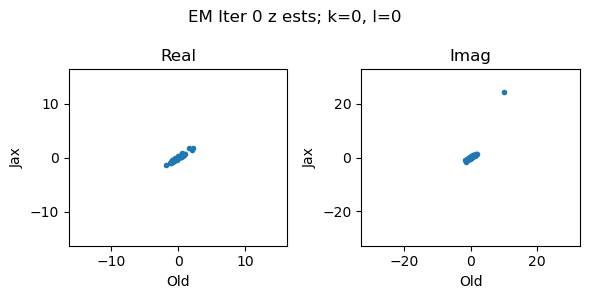

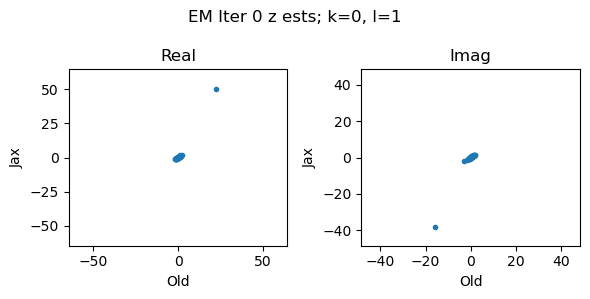

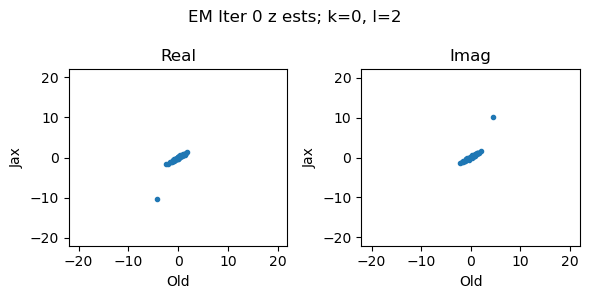

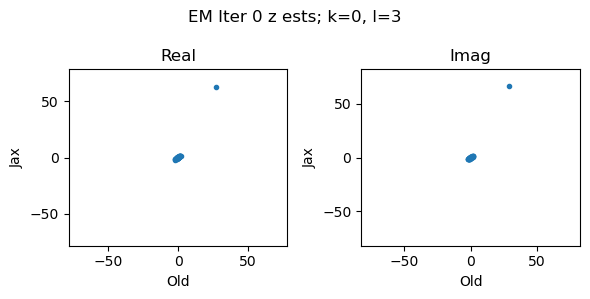

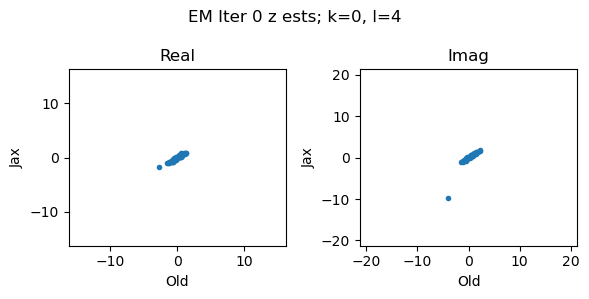

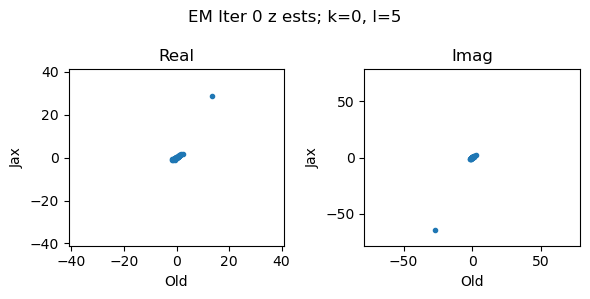

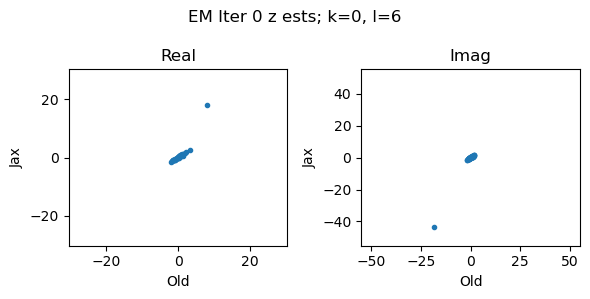

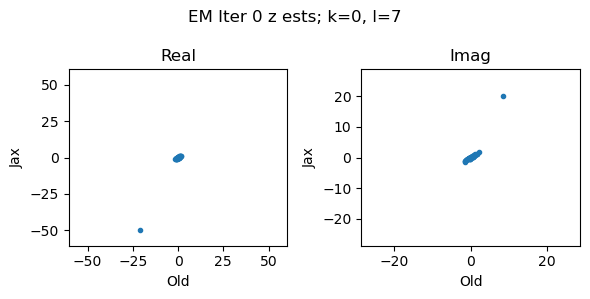

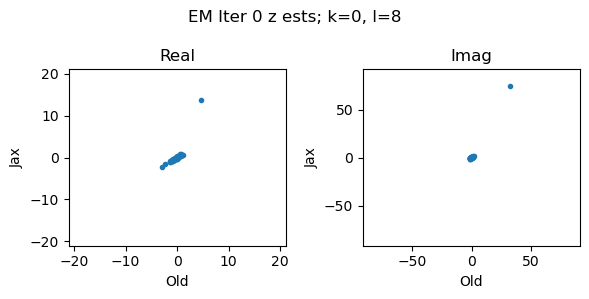

In [79]:
for l in range(9):
    plot_comp_mus(old_track, jax_track, 0, 0, l)

In [157]:
jnp.take(old_mus[:,:9], 2, axis=0)

Array([ 2.3482354 , -1.1574926 , -0.5212157 ,  0.9765176 , -1.8347485 ,
       -0.4837281 , -2.925897  ,  5.328524  , -0.43092835], dtype=float32)

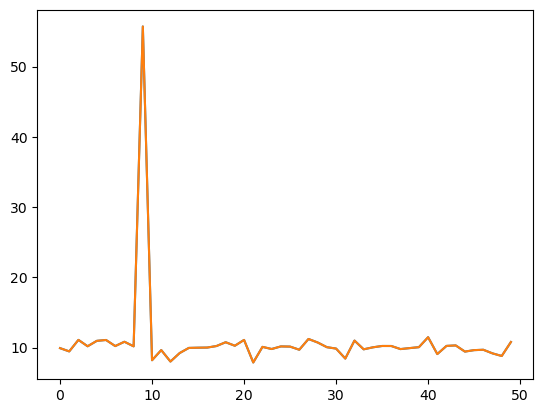

In [28]:
# Confirm same samples are being used for jax v old runs
k = 0
# plt.plot(gamma_oracle_jaxruns[nz,k,k].real)
# plt.plot(gamma_oracle[nz,k,k].real)
plt.plot(10*jnp.log10(gamma_oracle_jaxruns[nz,k,k].real))
plt.plot(10*jnp.log10(gamma_oracle[nz,k,k].real))

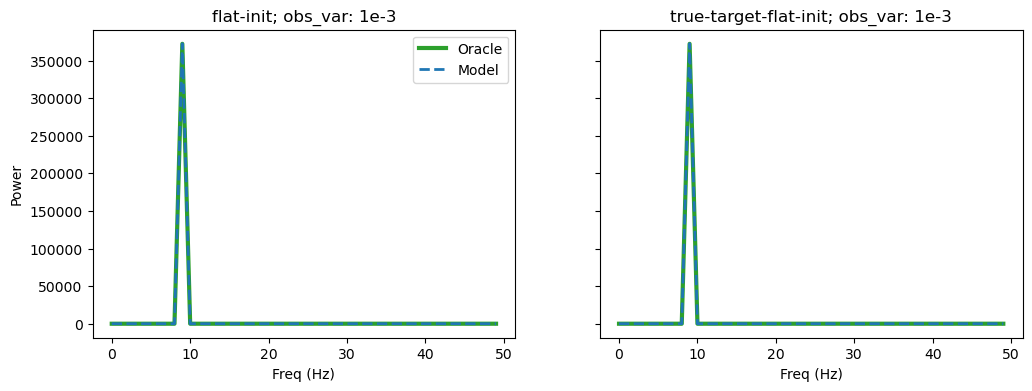

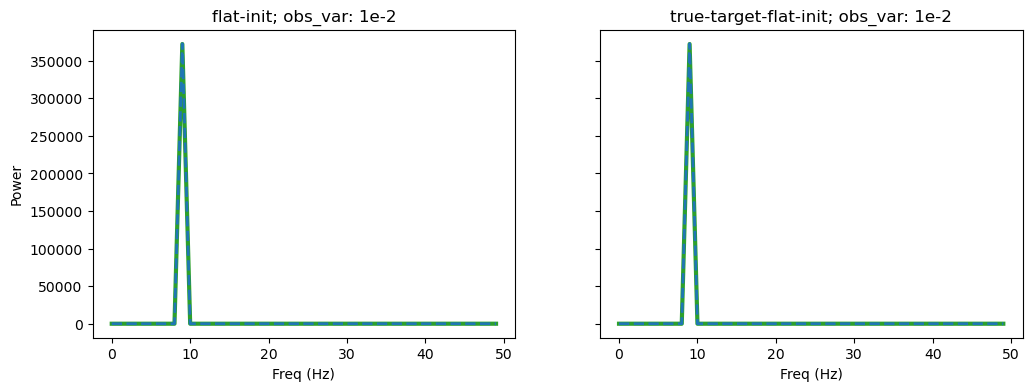

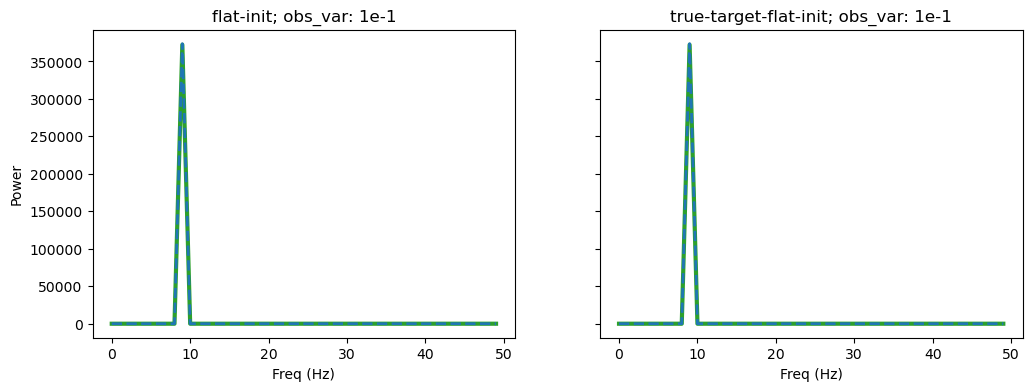

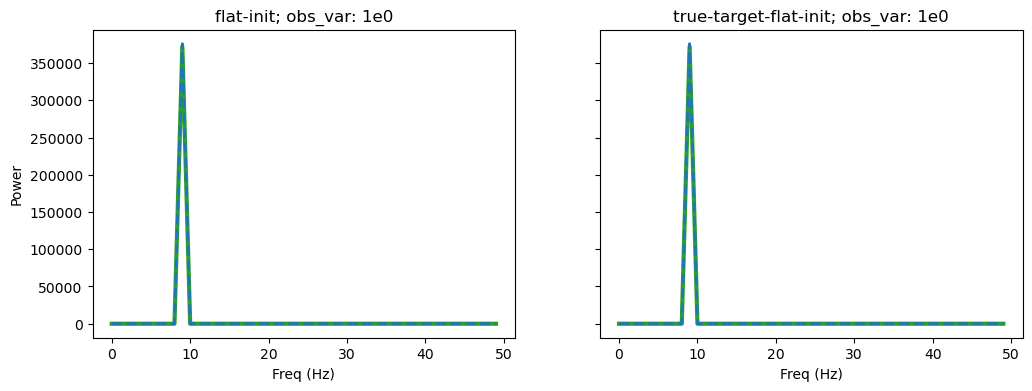

In [ ]:

# ovs_sel = [-3, -1]
# ovs = [-3, -1]
llim = 370000
hlim = 375000
dB = False
# ov = -1
init = inits[0]
res_to_plot_flat = load_results(res_paths, ovs_sel=ovs_sel, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
init = inits[1]
res_to_plot_true_target = load_results(res_paths, ovs_sel=ovs_sel, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
# for ov in [-2, -1]:
for ov in ovs:
    fshow = freqs[nz_fit50] <= 50
    fig, ax = plt.subplots(1,2,figsize=(12,4), sharey=True)
    # fig, ax = plt.subplots()
    plot_result_allfreqs(ax[0], res_to_plot_flat[ov], db=dB, fshow=fshow)
    plot_result_allfreqs(ax[1], res_to_plot_true_target[ov], db=dB, fshow=fshow)
    ax[0].set_title(f'flat-init; obs_var: 1e{ov}')
    ax[1].set_title(f'true-target-flat-init; obs_var: 1e{ov}')
    ax[0].set_xlabel('Freq (Hz)')
    ax[1].set_xlabel('Freq (Hz)')
    if dB is True:
        ax[0].set_ylabel('Power (dB)')
    else:
        ax[0].set_ylabel('Power')

    # ax.set_ylim([0,20000])
    if ov == -3:
        ax[0].legend()
    # ax[0].set_ylim([llim,hlim])
    # ax[1].set_ylim([llim,hlim])
    # ax[0].set_xlim([8.9,9.1])
    # ax[1].set_xlim([8.9,9.1])


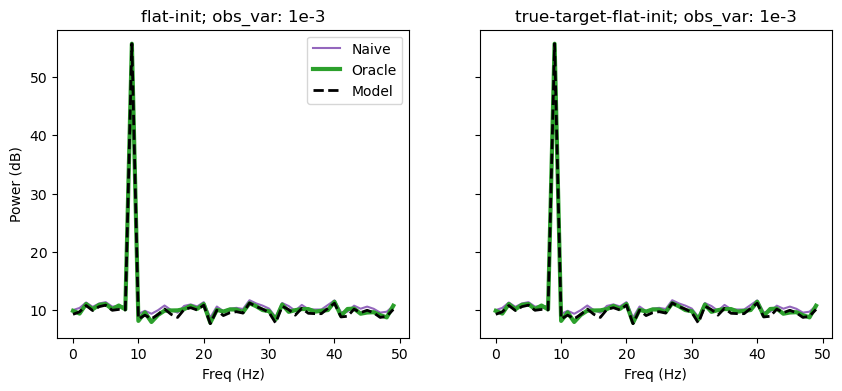

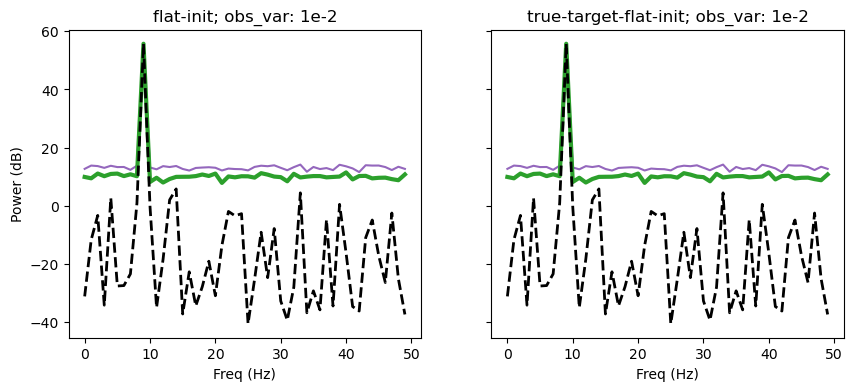

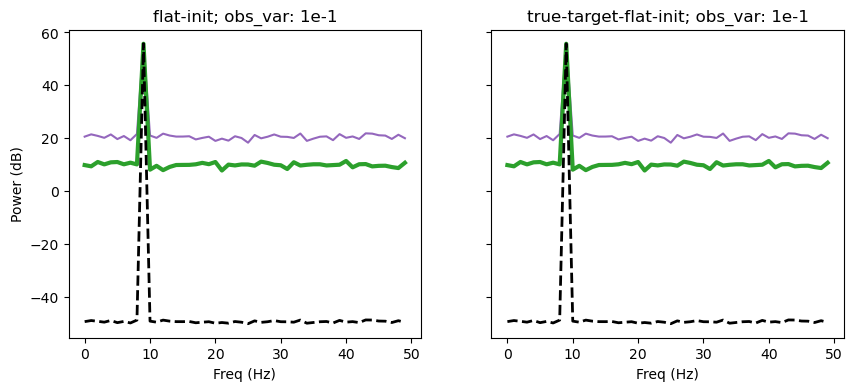

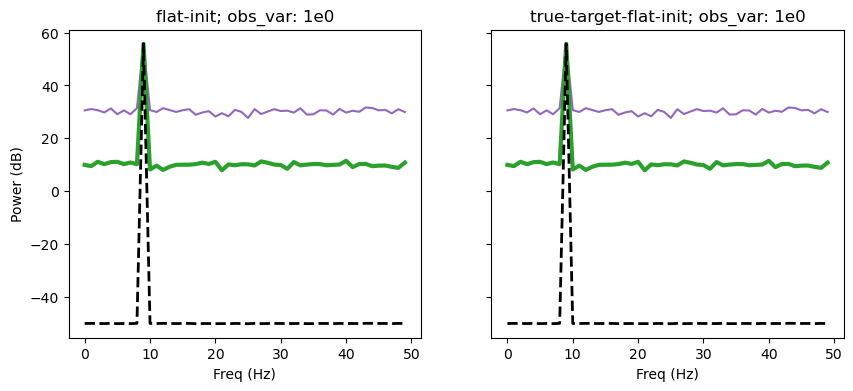

In [ ]:
ovs = [-3, -2, -1, 0]
ovs_sel = ovs
dB = True
init = 'flat-init'
res_to_plot_flat = load_results(res_paths, ovs_sel=ovs_sel, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
init = 'true-target-flat-offtarget'
res_to_plot_true_target = load_results(res_paths, ovs_sel=ovs_sel, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
for ov in ovs:
    fshow = freqs[nz_fit50] <= 50
    fig, ax = plt.subplots(1,2,figsize=(10,4), sharey=True)
    # fig, ax = plt.subplots()
    plot_result_allfreqs(ax[0], res_to_plot_flat[ov], db=dB, fshow=fshow)
    plot_result_allfreqs(ax[1], res_to_plot_true_target[ov], db=dB, fshow=fshow)
    ax[0].set_title(f'flat-init; obs_var: 1e{ov}')
    ax[1].set_title(f'true-target-flat-init; obs_var: 1e{ov}')
    ax[0].set_xlabel('Freq (Hz)')
    ax[1].set_xlabel('Freq (Hz)')
    if dB is True:
        ax[0].set_ylabel('Power (dB)')
    else:
        ax[0].set_ylabel('Power')

    # ax.set_ylim([0,20000])
    if ov == -3:
        ax[0].legend()
